<a href="https://colab.research.google.com/github/garychumd/highflow/blob/master/Harrison_Sept21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the libraries that we will be needing for this application.

In [1]:
#necessary to run
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns
import xgboost as xgb
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Give permissions to Google to access the data from your Google Drive.

In [2]:
#necessary to run
drive.mount("drive", force_remount=True)

Mounted at drive


Tell the application where the data is located and have it store the data so we can use it later.

In [3]:
#necessary to run
df = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Covid Data/Covid Master 300.csv', header=1, dtype=str)

Show the first 10 points of data.

In [4]:
df.head(10)

,Case #,Admission Date,Age,Sex,Ethnicity,Zip code,DM,HTN,Prior MI (Stent CABG),CHF (HFrEF),CHF (HFpEF),OSA,Sick Contact hospitalized?,Chronic Lung Disease (COPD etc),Immunne suppressed / Transplant,Liver Cirrhosis,ESRD on HD,Active Smoker / Vaping,Fomer smoker / vaper,Active pregnancy,BMI,Weight (kg),SBP,DBP,P,R,Rom Air Sat,Temp (F),Zero to 60 L oxygen,Oxyen sat on highest oxygen,CPAP / BiPAP,Intubation,HGBA1c (+/1 100 days),WBC,HGB,Creat,ALT,TBILI,CRP,DDimer,Ferritin,LDH,Decadron,Remdesivir,Convalesent Plasma,SBP.1,DBP.1,P.1,R.1,Temp (F).1,Zero to 60 L oxygen.1,Oxyen sat on highest oxygen.1,CPAP / BiPAP.1,Intubation.1,WBC.1,HGB.1,Creat.1,ALT.1,TBILI.1,CRP.1,DDimer.1,Ferritin.1,LDH.1,Zero to 60 L oxygen.2,Oxyen sat on highest oxygen.2,CPAP / BiPAP.2,Intubation.2,Dead in 30 days,Crash > 4 days
0,1,6/14/2020,46,M,Latino,95822,no,no,no,no,no,no,no,no,no,no,no,no,no,no,28.87,102,139,71,117,24,75,103.3,6,91,no,no,6.2,14.4,10.9,0.86,37,0.8,14.5,0.57,652,375,yes,yes,no,115,65,78,28,99.9,60,97,yes,no,12.5,10.5,0.62,31,0.4,17,0.97,1111,684,yes,92,yes,no,no,NaN
1,2,6/16/2020,50,M,Latino,95624,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,26.37,88.2,129,82,112,20,85,101,5,94,no,no,5.5,9.4,16.8,0.77,115,0.4,14.6,10.6,1443,621,yes,yes,no,126,83,68,20,98.2,12,93,no,no,8,16.3,0.68,79,0.5,6.3,0.82,1472,361,yes,93,no,no,no,NaN
2,3,6/28/2020,85,M,Latina,95632,yes,yes,yes,yes,no,no,no,no,no,no,no,no,yes,no,29.42,80.2,151,71,80,16,96,99,0,96,no,no,9.2,8.4,9.6,2.46,8,0.9,NaN,NaN,NaN,NaN,no,no,no,134,66,100,24,100.3,2,99,no,no,9.8,10.1,2.34,10,0.8,23.9,2.62,244,252,no,96,no,no,no,yes
3,4,6/28/2020,82,M,Latino,95828,yes,no,no,no,no,no,yes,yes,no,no,no,no,no,no,30.26,75.8,115,67,88,20,93,99.9,0,93,no,no,7.3,4.8,14.7,1.08,35,0.5,NaN,NaN,NaN,NaN,yes,yes,no,127,70,64,26,97.5,6,90,no,no,4.9,14.2,0.98,36,0.3,NaN,0.3,10,1300,yes,94,yes,no,yes,NaN
4,5,7/1/2020,66,F,Caucasian,95823,no,no,no,no,no,no,no,no,no,no,no,no,no,no,18.72,49.5,163,84,118,20,83,100.8,30,98,no,no,5.5,6.2,12.4,2.05,19,0.5,NaN,NaN,NaN,NaN,yes,no,no,107,94,92,20,97.9,40,95,no,no,7.2,11.4,0.77,18,0.2,23.9,NaN,184,537,yes,90,yes,no,no,NaN
5,6,7/4/2020,83,M,Caucasian,95693,yes,yes,no,no,no,no,no,yes,no,no,no,no,yes,no,29,97,140,61,106,18,93,100.1,0,93,no,no,6.8,8.8,15.7,0.78,31,0.9,0.8,242,589,153,yes,no,no,124,61,61,19,97.3,2,96,no,no,12.3,13.5,0.67,26,0.8,1.4,1.03,680,158,no,97,no,no,no,yes
6,7,7/5/2020,65,M,Hmong,95820,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,25.02,70.3,133,82,114,28,85,98.8,2,97,no,no,10,9.8,12.2,1.24,22,0.6,8,0.32,533,336,yes,yes,no,137,80,94,24,98,40,94,no,no,10.6,12.1,0.85,16,1,9.4,0.45,569,365,yes,96,no,yes,no,NaN
7,8,7/9/2020,45,M,Caucasian,95820,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,40.05,141.5,148,89,111,22,89,102.9,2,97,no,no,6,5.3,15.9,0.65,31,0.5,10.9,0.41,1044,621,yes,no,no,131,73,94,18,98.7,6,95,no,no,8,11,0.57,21,0.4,12.7,0.61,1027,653,yes,95,no,no,no,NaN
8,9,7/10/2020,79,M,Latino,95632,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,33.11,95.9,141,76,77,19,90,98.5,2,96,no,no,8.6,5.6,13.1,1.47,22,0.8,9.1,0.58,892,491,yes,no,no,180,82,70,20,98.7,35,92,no,no,8.7,13.2,0.62,18,0.8,4.2,0.78,NaN,474,yes,96,no,no,yes,NaN
9,10,7/11/2020,76,F,Caucasian,95823,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,33.34,83,124,55,120,24,81,101.2,4,98,no,no,7.4,5.8,11.6,0.85,26,0.6,10.4,0.54,285,225,yes,no,no,100,53,75,22,98.2,6,91,no,no,7.8,11.5,0.61,37,0.4,5.9,0.34,397,292,yes,91,yes,no,no,transfer to ICU on day 3


Print out the data types of all our columns/factors.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Case #                           302 non-null    object
 1   Admission Date                   302 non-null    object
 2   Age                              302 non-null    object
 3   Sex                              302 non-null    object
 4   Ethnicity                        302 non-null    object
 5   Zip code                         302 non-null    object
 6   DM                               302 non-null    object
 7   HTN                              302 non-null    object
 8   Prior MI (Stent CABG)            302 non-null    object
 9   CHF (HFrEF)                      302 non-null    object
 10  CHF (HFpEF)                      302 non-null    object
 11  OSA                              302 non-null    object
 12  Sick Contact hospitalized?       302

XGBoost does not accept the object data type so we have to convert any entires we need to a float or bool.

In [6]:
yesNoList = ['DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
'OSA','Sick Contact hospitalized?','Chronic Lung Disease (COPD etc)','Immunne suppressed / Transplant',
'Liver Cirrhosis','ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy',
'CPAP / BiPAP','Intubation','Decadron','Remdesivir','Convalesent Plasma', 'CPAP / BiPAP.1', 'Intubation.1',
'CPAP / BiPAP.2','Intubation.2','Dead in 30 days','Crash > 4 days', 'Zero to 60 L oxygen.2', 'Dead in 30 days']
convertDict = {'Age':float, 'Zip code':float, 'BMI':float, 'Weight (kg)':float, 'SBP':float, 'DBP':float, 'P':float, 'R':float,
               'Rom Air Sat':float, 'Temp (F)':float, 'Zero to 60 L oxygen':float,
               'Oxyen sat on highest oxygen':float, 'HGBA1c (+/1 100 days)':float, 'WBC':float,
               'HGB':float, 'Creat':float, 'ALT':float, 'TBILI':float, 'CRP': float, 'DDimer': float,
	       'Ferritin':float, 'LDH':float, 'SBP.1':float, 'DBP.1': float, 'P.1':float, 'R.1':float,
               'Temp (F).1':float, 'Zero to 60 L oxygen.1':float, 'Oxyen sat on highest oxygen.1':float,
               'WBC.1':float, 'HGB.1':float, 'Creat.1':float, 'ALT.1':float, 'TBILI.1':float,
               'CRP.1':float, 'DDimer.1':float, 'Ferritin.1':float, 'LDH.1':float, 'DM':bool, 'HTN':bool,
	       'Prior MI (Stent CABG)':bool, 'Chronic Lung Disease (COPD etc)':bool, 'ESRD on HD':bool,
	       'CPAP / BiPAP':bool, 'Intubation':bool, 'Decadron':bool, 'Remdesivir':bool, 'Convalesent Plasma':bool,
	       'CPAP / BiPAP.1':bool, 'Intubation.1':bool
               }

for i in yesNoList:
    df[i] = df[i].map({'yes':True, 'no':False, 'Yes':True, 'No':False, 'yes ':True, 'no ':False})
df['Sex'] = df['Sex'].map({'M': False, 'F': True})
df = df.astype(convertDict)

We can check to make sure that the data was converted properly if the data types have changed.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Case #                           302 non-null    object 
 1   Admission Date                   302 non-null    object 
 2   Age                              302 non-null    float64
 3   Sex                              302 non-null    bool   
 4   Ethnicity                        302 non-null    object 
 5   Zip code                         302 non-null    float64
 6   DM                               302 non-null    bool   
 7   HTN                              302 non-null    bool   
 8   Prior MI (Stent CABG)            302 non-null    bool   
 9   CHF (HFrEF)                      302 non-null    bool   
 10  CHF (HFpEF)                      302 non-null    bool   
 11  OSA                              302 non-null    bool   
 12  Sick Contact hospitali

Create some pie charts that will help visualize our data.

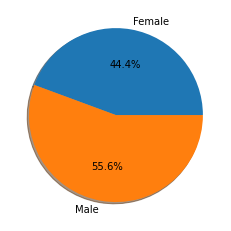

In [8]:
labels = 'Female', 'Male'
sizes = [df.loc[df['Sex'] == True].shape[0], df.loc[df['Sex'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

Oxygen Requirement in 96 hours


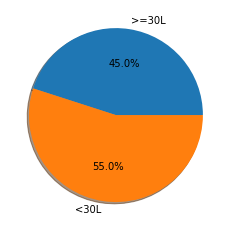

In [9]:
print('Oxygen Requirement in 96 hours')
labels = '>=30L ', '<30L'
sizes = [df.loc[df['Zero to 60 L oxygen.2'] == 1].shape[0], df.loc[df['Zero to 60 L oxygen.2'] == 0].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

In [10]:
#Create a pie chart for the "Death" factor

Create some histograms to show correlations between certain factors.

       Low Oxygen        vs     High Oxygen


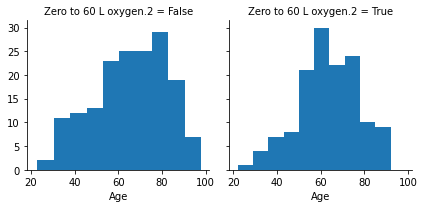

In [11]:
g = sns.FacetGrid(df, col="Zero to 60 L oxygen.2")
print("       Low Oxygen        vs     High Oxygen")
g.map(plt.hist, "Age");

       Low Oxygen        vs     High Oxygen


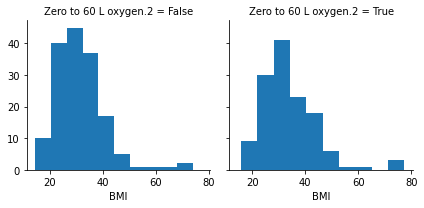

In [12]:
g = sns.FacetGrid(df, col="Zero to 60 L oxygen.2")
print("       Low Oxygen        vs     High Oxygen")
g.map(plt.hist, "BMI");

In [13]:
#create a histogram that shows Oxygen3 as col and weight as a correlation

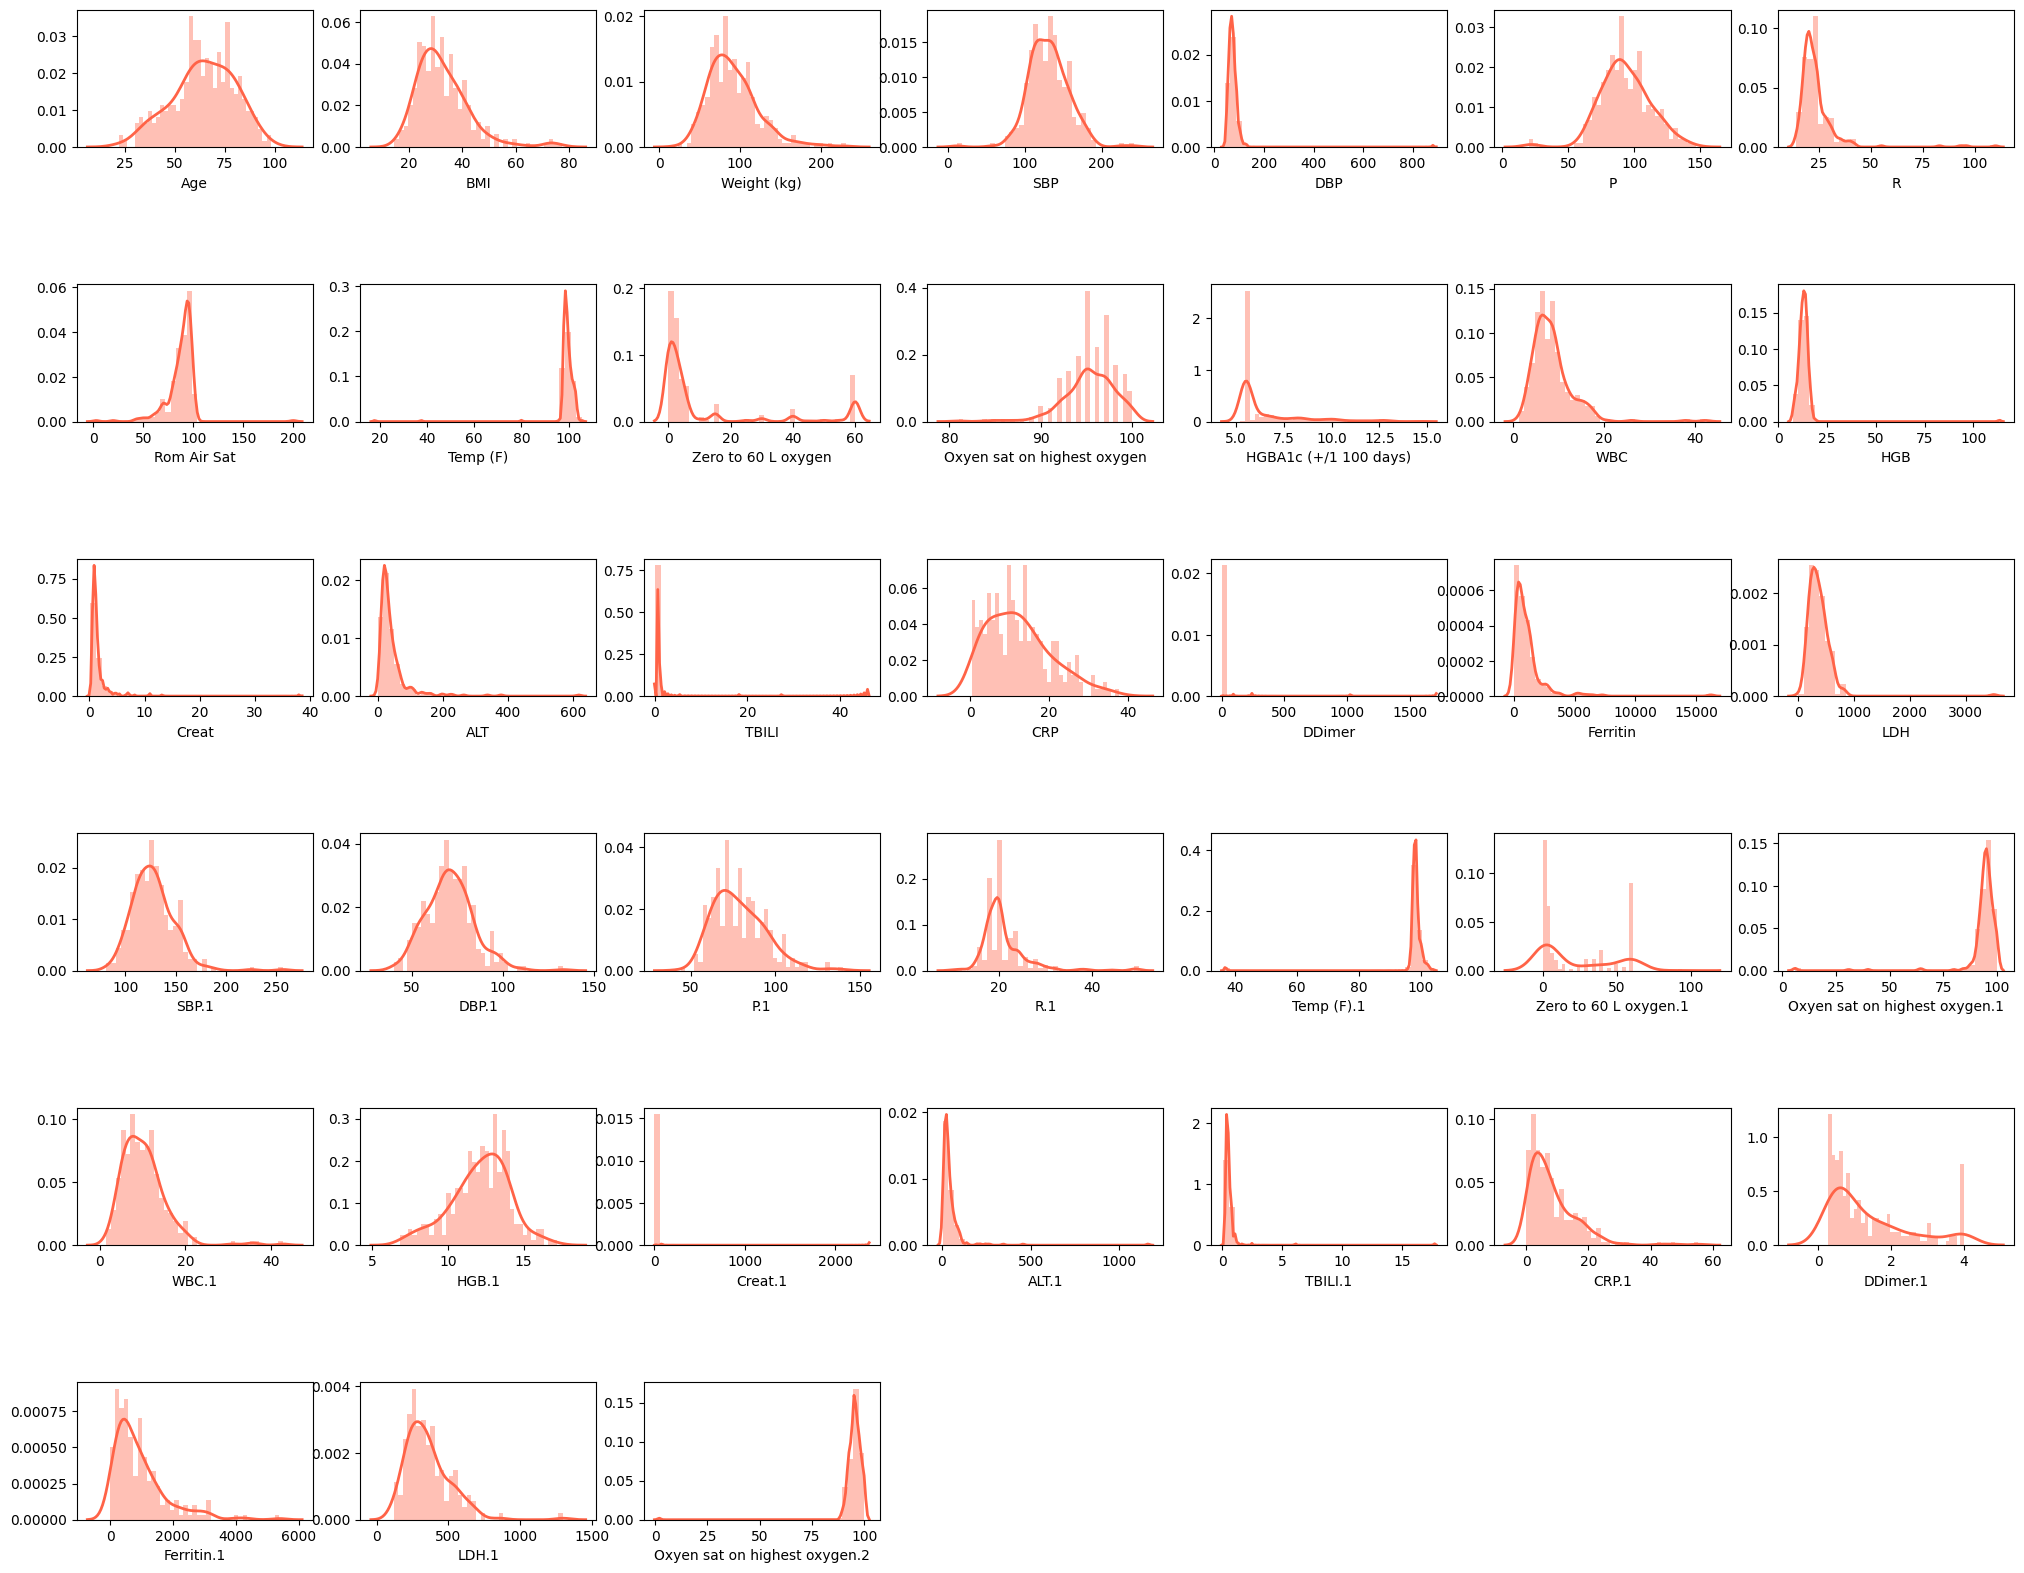

In [17]:
graphList = ['Age', 'BMI', 'Weight (kg)', 'SBP', 'DBP', 'P', 'R',
               'Rom Air Sat', 'Temp (F)', 'Zero to 60 L oxygen',
               'Oxyen sat on highest oxygen', 'HGBA1c (+/1 100 days)', 'WBC',
               'HGB', 'Creat', 'ALT', 'TBILI', 'CRP', 'DDimer',
               'Ferritin', 'LDH', 'SBP.1', 'DBP.1', 'P.1', 'R.1',
               'Temp (F).1', 'Zero to 60 L oxygen.1', 'Oxyen sat on highest oxygen.1',
               'WBC.1', 'HGB.1', 'Creat.1', 'ALT.1', 'TBILI.1',
               'CRP.1', 'DDimer.1', 'Ferritin.1', 'LDH.1',
               'Oxyen sat on highest oxygen.2']
graphs = plt.figure(figsize=(25,20),dpi=100)
plt.subplots_adjust(hspace=1)
#plt.title('Patient Data Distributions')
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(6,7,k)
    sns.distplot(df[graphList[k-1]], hist=True, kde=True, bins=int(len(df)/8), color = 'tomato', kde_kws={'linewidth': 2})
    #plt.ylabel('Frequency')
    #plt.title(graphList[k-1] + ' distribution')

Output data and statistics.

In [14]:
df.loc(0)[4]
#Get the information for the fifth patient

Case #                                   5
Admission Date                    7/1/2020
Age                                     66
Sex                                   True
Ethnicity                        Caucasian
                                   ...    
Oxyen sat on highest oxygen.2           90
CPAP / BiPAP.2                        True
Intubation.2                         False
Dead in 30 days                        NaN
Crash > 4 days                         NaN
Name: 4, Length: 69, dtype: object

In [15]:
#output the number of deaths and the number of total cases
print("Total number of Deaths:")
print(len(df.loc[df['Death'] == 1]))
print("")
print("Total number of Deaths: " + str(len(df.loc[df['Death'] == 1])))
print("Total Cases: " + str(len(df)))
print("Mortality Rate: " + str(len(df.loc[df['Death'] == 1])/len(df)))

Total number of Deaths:


KeyError: ignored

Some other ways to create histograms.

In [ ]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(2,5,1)
sns.distplot(df['Age'])
fig.add_subplot(2,5,2)
sns.distplot(df['Temp'])
fig.add_subplot(2,5,3)
sns.distplot(df['CRP'])
fig.add_subplot(2,5,4)
sns.distplot(df['DDimer'])
fig.add_subplot(2,5,5)
sns.distplot(df['Ferritin'])
fig.add_subplot(2,5,6)
sns.distplot(df['LDH'])


In [ ]:
graphList = ['Age', 'BMI', 'Wt']
graphs = plt.figure(figsize=(25,20),dpi=100)
plt.subplots_adjust(hspace=1)
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(6,7,k)
    sns.distplot(df[graphList[k-1]], hist=True, kde=True, bins=int(len(df)/8), color = 'tomato', kde_kws={'linewidth': 2})

Let's start implementing the machine learning part of this application.

In [ ]:
inputColumns = ['Age','Sex','Zip', 'BMI', 'Wt', 'Oxygen',
               'CRP', 'DDimer',	'Ferritin',	'LDH',
               'Oxygen2', 'CRP2', 'DDimer2', 'Ferritin2',
               'LDH2']
outputColumn = 'Oxygen3'

inputData = df[inputColumns] #"X"
outputData = df[outputColumn] #"Y"

print(inputData)
print(outputData)


In [ ]:
inputTrain, inputTest, outputTrain, outputTest = train_test_split(inputData, outputData, test_size = .3, random_state = 42)


In [ ]:
trainMatrix = xgb.DMatrix(inputTrain, label=outputTrain, feature_names=inputColumns[:15])
testMatrix = xgb.DMatrix(inputTest, label=outputTest, feature_names=inputColumns[:15])


In [ ]:
param_grid = {'eta':[.3,.25,.2,.15,0.1,.075], 'max_depth':np.arange(1,10,5).tolist(), 'subsample':np.arange(1,0.1,-0.45).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.45).tolist(), 'min_child_weight':np.arange(1,100,45).tolist()}
bestParams = {}
lowestError = 2048

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:
                    cvResults = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}, trainMatrix, num_boost_round=600, seed=2, nfold=5, early_stopping_rounds=125)
                    if abs(cvResults['test-{}-mean'.format('error')]).min() < lowestError:
                        lowestError = abs(cvResults['test-{}-mean'.format('error')]).min()
                        bestParams = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}
                    print(str(abs(cvResults['test-{}-mean'.format('error')]).min()) + ' , ' + str(lowestError))
print(bestParams)
print(lowestError)

In [ ]:
model = xgb.train(bestParams, trainMatrix, 1000, evals=[(testMatrix, "Test")], early_stopping_rounds=1000)


In [ ]:
model.save_model('/content/drive/My Drive/modelName.model')

In [ ]:
outputTrainPredict = model.predict(trainMatrix)
outputTestPredict = model.predict(testMatrix)

print("The Results of _____'s Model:\n")
print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\n\t   Predicted")
print(pd.crosstab(outputTest, outputTestPredict.round()))
#print(outputTest)
#print(abs(outputTestPredict.round()))

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0


for i in range(len(outputTest)):
  if outputTest.values[i] == True and outputTestPredict.round()[i] == 1:
    truePositive = truePositive + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 0:
    trueNegative = trueNegative + 1
  elif outputTest.values[i] == True and outputTestPredict.round()[i] == 0:
    falseNegative = falseNegative + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 1:
    falsePositive = falsePositive + 1
print("\nTrue Positives: " + str(truePositive))
print("True Negatives: " + str(trueNegative))
print("False Negatives (Type II error): " + str(falseNegative))
print("False Positives (Type I error): " + str(falsePositive))
print("Sensitivity: " + str(truePositive / (truePositive + falseNegative)))
print("Specificity: " + str(trueNegative / (trueNegative + falsePositive)))
print("Positve Predicted Rate: " + str(truePositive / (truePositive + falsePositive)))
print("Negative Predicted Rate: " + str(trueNegative / (trueNegative + falseNegative)) + "\n")

fig, ax = plt.subplots(figsize=(15,12))
xgb.plot_importance(model, ax=ax)

In [ ]:
dataList = []
dataList.append(int(input("Enter Age: ")))
gender = input("Enter Gender (M or F): ")
if gender == "F": dataList.append(True)
else: dataList.append(False)
dataList.append(int(input("Enter Zip Code: ")))
dataList.append(float(input("Enter BMI: ")))
dataList.append(float(input("Enter Weight: ")))
dataList.append(float(input("Enter Oxygen: ")))
dataList.append(float(input("Enter CRP: ")))
dataList.append(float(input("Enter DDimer: ")))
dataList.append(float(input("Enter Ferritin: ")))
dataList.append(float(input("Enter LDH: ")))
dataList.append(float(input("Enter Oxygen2: ")))
dataList.append(float(input("Enter CRP2): ")))
dataList.append(float(input("Enter DDimer2: ")))
dataList.append(float(input("Enter Ferritin2: ")))
dataList.append(float(input("Enter LDH2: ")))

print(dataList)
#dataList = [82,	False,	95828,	30.26,	75.8,	0, 9.1, 1.39, 650, 550, 50, 12.5, 1, 800, 600]
df2 = pd.DataFrame(np.array([dataList]),)
exampleMatrix = xgb.DMatrix(df2, label=outputTrain, feature_names=inputColumns[:15])
exampleResult = model.predict(exampleMatrix).round()
if exampleResult == 1:
  print("Predicted Result: Oxygen") 
else:
  print("Predicted Result: No Oxygen")
